# Intro

### 1. What this dataset is:

This dataset contains scRNA-seq measurements taken from entorhinal cortex samples from control and Alzheimer’s disease brains (`n=6` per group).
Cells are labeled with cell type information as well as patient condition (i.e., healthy or with Alzheimer's).


### 2. Where the data comes from:

This data was collected as part of [A single-cell atlas of entorhinal cortex from individuals with Alzheimer’s disease reveals cell-type-specific gene expression regulation (Grubman et al., 2019)](https://www.nature.com/articles/s41593-019-0539-4) and was deposited in the NIH gene expression omnibus as `GSE138852`.

### 3. Why this data might be useful:

This data could potentially be useful in understanding which genes/pathways are involved in Alzheimer's disease. As of this writing, there do not appear to be any computational papers making use of this data.

### First, we download the data from the NIH Gene Expression Omnibus and write it to disk.

In [1]:
import requests

print('Downloading compressed data')

data_url = 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE138852&format=file&file=GSE138852%5Fcounts%2Ecsv%2Egz'
metadata_url = 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE138852&format=file&file=GSE138852%5Fcovariates%2Ecsv%2Egz'

compressed_data_file_name = './GSE138852_counts.csv.gz'
compressed_metadata_file_name = './GSE138852_covariates.csv.gz'

r = requests.get(data_url)
with open(compressed_data_file_name, 'wb') as f:
    f.write(r.content)
    
r = requests.get(metadata_url)
with open(compressed_metadata_file_name, 'wb') as f:
    f.write(r.content)
    
print("Data successfully written to disk")

Data successfully written to disk


### Next, we read in the files and begin preprocessing

(This may take a couple minutes since the files are pretty big)

In [5]:
import gzip
import pandas as pd

with gzip.open(compressed_data_file_name, 'rb') as f:
    data_df = pd.read_csv(f, index_col=0)
    
with gzip.open(compressed_metadata_file_name, 'rb') as f:
    metadata_df = pd.read_csv(f, index_col=0)

The data was originally stored with each gene being a row and each cell being a column. We'll transpose our data matrix to have a more standard arrangement of rows being samples and features being columns

In [8]:
data_df = data_df.transpose()

We'll also take a quick look at our metadata to see what information we're given.

In [10]:
metadata_df.head()

,oupSample.batchCond,oupSample.cellType,oupSample.cellType_batchCond,oupSample.subclustID,oupSample.subclustCond
AAACCTGGTAGAAAGG_AD5_AD6,AD,oligo,oligo_AD,o3,AD
AAACCTGGTAGCGATG_AD5_AD6,AD,oligo,oligo_AD,o3,AD
AAACCTGTCAGTCAGT_AD5_AD6,AD,oligo,oligo_AD,o3,AD
AAACCTGTCCAAACAC_AD5_AD6,AD,oligo,oligo_AD,o3,AD
AAACCTGTCCAGTATG_AD5_AD6,AD,oligo,oligo_AD,o3,AD


From a quick look at the data, it seems like we were provided patient status in the `oupSample.batchCond` column, cell types in the `oupSample.cellType` column, as well as some clustering information in the other columns

---

Now we'll perform some standard preprocessing steps on our scRNA-seq data. First, we'll normalize the data so that count numbers are comparable across cells, log-transform the resulting normalized counts, and then select the 2,000 most variable genes. To do so, we'll use functions from `scanpy`, a popular Python library for handling scRNA-seq data.

In [11]:
import scanpy as sc
from anndata import AnnData

adata = AnnData(X = data_df.values, obs=metadata_df) # The annotated dataframe (AnnData) is a wrapper class used by scanpy for most of its functions.
sc.pp.normalize_total(adata, 1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

To confirm that our preprocessed data looks reasonable before saving it, we'll use the UMAP algorithm to visualize it in 2D.

         Falling back to preprocessing with `sc.pp.pca` and default params.
/homes/gws/ewein/miniconda3/envs/Datasets/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'oupSample.batchCond' as categorical
/homes/gws/ewein/miniconda3/envs/Datasets/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'oupSample.cellType' as categorical
/homes/gws/ewein/miniconda3/envs/Datasets/lib/python3.9/site-packages/anndata/_core/ann

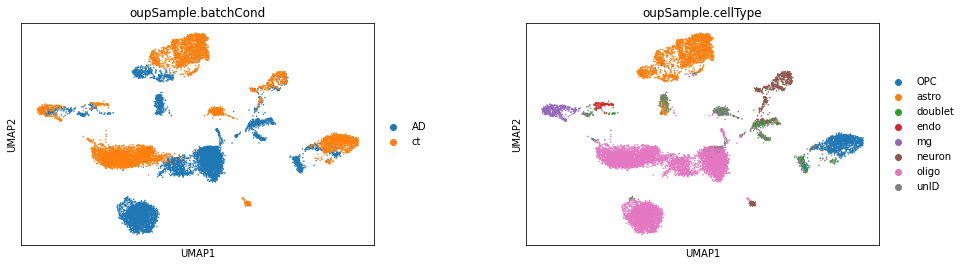

In [12]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['oupSample.batchCond', 'oupSample.cellType'], wspace=0.3)

Our UMAP plots look sensible (e.g. we see good separation between cell types and disease state), so we'll proceed with saving the final version.

In [13]:
df = pd.DataFrame(adata.X[:, adata.var['highly_variable']]) # Extract values for highly variable genes only

df.to_csv('./preprocessed_data.csv')
metadata_df.to_csv('./metadata.csv')